# Logistic Regression

I'll try to combine methods from two of the previous notebooks to create a simple logistc regression classification for the [IRIS dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set). The idea is to classify the flower type based on it's sepal length and width as well as petal length as width.

Since we're getting started, let's make things easier by classifying only between 2 different outputs - we will discard Virginica.

### Analyse and preprocess the data

First let's have a look at the data and visualize it.

In [1]:
import math
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
iris = pd.read_csv('./../datasets/IRIS.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


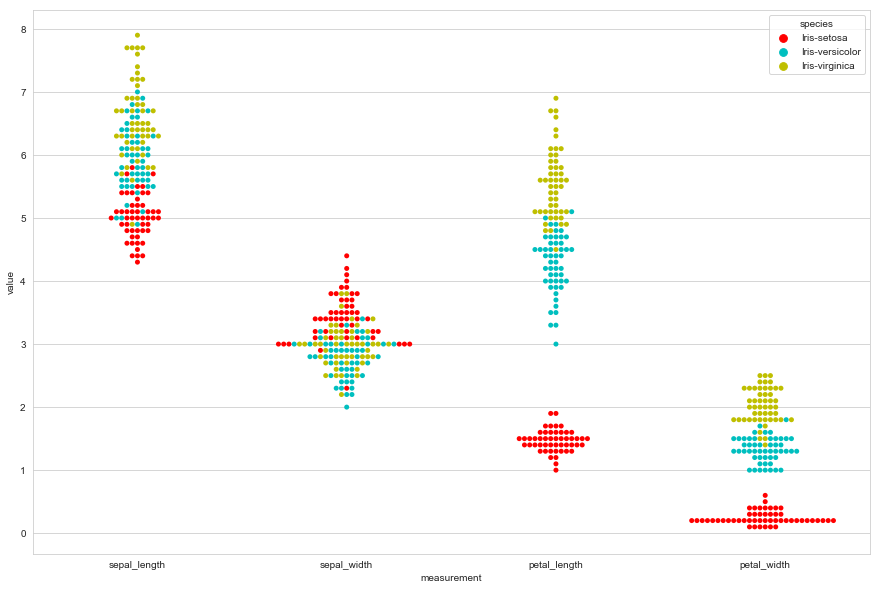

In [3]:
ax = pd.melt(iris, 'species', var_name='measurement')

plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")
sns.swarmplot(x='measurement', y='value', hue='species',
              palette=['r', 'c', 'y'], data=ax)

In [4]:
# Remove one of the species to make it a binary classification - setosa as this is clearly distinguishable based on petal_length
iris = iris[iris['species'] != 'Iris-setosa']

# Label encode the species
mappings = {'Iris-virginica': 0, 'Iris-versicolor': 1}
iris['species'] = iris['species'].map(mappings)

# Use standard scaling on the rest of the features
std = iris.drop(['species'], axis=1).std()
mean = iris.drop(['species'], axis=1).mean()

for column in iris.drop(['species'], axis=1).columns:
    iris[column] = iris[column].apply(lambda x: (x-mean[column])/std[column])
    
# Finally, let's shuffle the dataset
iris = iris.sample(frac=1)

In [5]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
60,-1.903945,-2.620578,-1.703048,-1.591455,1
145,0.660798,0.384672,0.356114,1.469035,0
101,-0.697007,-0.516903,0.234987,0.527346,0
123,0.057330,-0.516903,-0.007268,0.291924,0
108,0.660798,-1.117953,1.082877,0.291924,0


In [6]:
inputs = iris.drop('species', axis=1).values
labels = np.array(iris.species)

In [7]:
# And lastly, let's append one's to the front of the dataset to serve as bias (intercept) term
inputs = np.hstack([np.ones([inputs.shape[0], 1]), inputs])

In [8]:
inputs[:5]

array([[ 1.        , -1.90394452, -2.6205781 , -1.7030483 , -1.59145509],
       [ 1.        ,  0.66079849,  0.38467201,  0.35611394,  1.46903547],
       [ 1.        , -0.69700663, -0.51690302,  0.23498675,  0.52734607],
       [ 1.        ,  0.05732955, -0.51690302, -0.00726763,  0.29192372],
       [ 1.        ,  0.66079849, -1.11795304,  1.08287709,  0.29192372]])

### Fitness

First let's define sigmoid activation function, used to map predictions (any real values) to probabilities (values between 0 and 1). The decision boundary will be set at 50%, so any value of:

    p <  0.5, class = 0
    p >= 0.5, class = 1

In [9]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

The regression function is very similar to the one we used to maximize the output in the previous exercise:

$$z = W_{0} + W_{1}x_{1} + W_{2}x_{2}... W_{n}x_{n}$$

The fitness function itself will be a cross entropy (log loss) function - our genetic algorithm will try to minimize this result.

$$J(\theta) = \frac{-1}{m} \sum_{i=1}^{m} [y^{(i)}log(h_{\theta}(x^{(i)}))+(1-y^{(i)})log(1-h_{\theta}(x^{(i))}))]$$

where m is a number of examples in out dataset.

Basically, the function penalizes for incorrect prediction on log scale - so it the real value is supposed to be 1, however our model predicted 0, we assign a huge penalty score to that entry. If the prediction is correct, the score is getting closer to 0, which is what we're aiming for. Or in other words, it penalizes confident and wrong predictions more than it rewards confident and right predictions.

We will use mean absolute error in out fitness function. We will also try to evolve both bias and weights at the same time.

In [10]:
def fitness(weights, inputs, labels):
    num_observations = inputs.shape[0]
    predictions = sigmoid(np.dot(weights, inputs.T))
    cost = -1/num_observations * np.sum(labels*np.log(predictions) + (1-labels)*np.log(1-predictions), axis=1)
    cost[np.isinf(cost)] = 0
    
    return cost

### Select parents

We sort the parents by best fitted individual (most minimized cost function) and pick specified number of those for reproduction. There is however 15% of chance (arbitrary number, hyperparameter) that the parent will be chosen at random from the whole list, rather than the next best.

In [11]:
def select_parents(population, most_fitted, num_parents, lucky_parent):
    sorts = most_fitted.argsort() # Get indices according to sorted ascending fitness costs
    
    parents = np.empty(num_parents)
    for i in range(num_parents[0]):
        if random.random() >= lucky_parent:
            parents[i, :] = population[sorts[i]]
        else:
            parents[i, :] = population[random.choice(sorts)]
            
    # np.random.shuffle(parents)
    return parents

### Crossover

Breeding will happen with a simple crossover - we take 2 best fitted parents and mix their values together to form an offspring. Everything from before crossover point at one parent will go to the child, and everything else, after the crossover point from the second parent, will go to the child as well in the same location as parent's locations. (ugh... I got mixed up in explanations)

The crossover point will be at random at location 2 or 3 (in this case - with different weight crossover point will happen in the middle of the lengths of that weights)

In [12]:
def crossover(parents, num_offsprings, num_weights):
    find_crossover_point = lambda x: math.floor(x) if random.random() < .5 else math.ceil(x)
    
    offsprings = np.empty(num_offsprings)
    for i in range(num_offsprings[0]):
        parent1_idx = i % parents.shape[0]
        parent2_idx = (i+1) % parents.shape[0]
        
        crossover_point = find_crossover_point(num_weights/2)
        offsprings[i, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offsprings[i, crossover_point:] = parents[parent2_idx, crossover_point:]
        
    return offsprings

### Mutation

This is a bit of a tougher question and I'm honestly not certain if I approach it correctly, but weights in logistic regression can take very diverse values depending on the estimated outcome. Thus, for each weight in each individual I'll add a 10% mutation chance (once again, hyperparameter), to add a uniform number between -1 and 1. Let's see how that works...

In [13]:
def mutation(offsprings, mutation_chance):
    for i in range(offsprings.shape[0]):
        for j in range(offsprings.shape[1]):
            if random.random() < mutation_chance:
                offsprings[i, j] += np.random.uniform(-1, 1)
                
    return offsprings

### Evolution time!

First let's split dataset into train/test sets, so we have something to compare accuracy to.

In [14]:
X_train = inputs[:80]
X_test = labels[:80]

y_train = inputs[80:]
y_test = labels[80:]

Set the hyperparameters:

In [15]:
NUM_INDIVIDUALS = 10
NUM_WEIGHTS = inputs.shape[1]
POPULATION_SIZE = (NUM_INDIVIDUALS, NUM_WEIGHTS)
NUM_GENERATIONS = 101

LUCKY_PARENT = .15
MUTATION_CHANCE = .10
NUM_PARENTS = (5, NUM_WEIGHTS)
NUM_OFFSPRINGS = (NUM_INDIVIDUALS-NUM_PARENTS[0], NUM_WEIGHTS)

And run the evolutions:

In [16]:
history = []
population = np.random.uniform(-1, 1, POPULATION_SIZE)

for generation in range(NUM_GENERATIONS):
    most_fitted = fitness(population, X_train, X_test)
    
    best_fitted_idx = np.where(fitness == np.min(fitness))
    best_weights = population[best_fitted_idx]
    best_score = np.min(most_fitted)
    history.append((generation, best_score, best_weights))
    
    if generation % 25 == 0:
        print('At generation #{}, cost function is: {}'.format(generation, best_score))
    
    parents = select_parents(population, most_fitted, NUM_PARENTS, LUCKY_PARENT)
    offsprings = crossover(parents, NUM_OFFSPRINGS, NUM_WEIGHTS)
    mutated_offsprings = mutation(offsprings, MUTATION_CHANCE)
    
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]:, :] = mutated_offsprings

At generation #0, cost function is: 0.48105000250473684
At generation #25, cost function is: 0.20129818541021166
At generation #50, cost function is: 0.10338130816799047
At generation #75, cost function is: 0.07081312826576272
At generation #100, cost function is: 0.06614864005339643


# Evaluation

Let's evaluate how the GA did learning the weights for the function.

In [17]:
generation, score, weights = zip(*history)

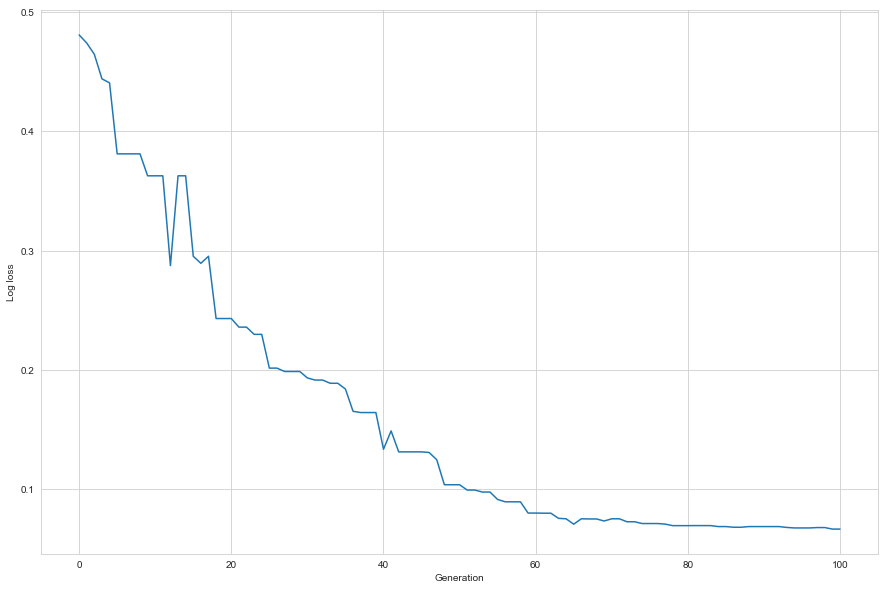

In [18]:
plt.figure(figsize=(15, 10))
ax = sns.lineplot(generation, score)
ax.set(xlabel='Generation', ylabel='Log loss')
plt.show()

In [21]:
def get_predictions(weights, inputs):
    predictions = sigmoid(np.dot(weights, inputs.T))
    return np.where(predictions > .5, 1, 0)

def get_accuracy(predictions, real_labels):
    return (predictions == real_labels).mean()

In [22]:
best_weights = weights[-1]

train_predictions = get_predictions(best_weights, X_train)
train_accuracy = get_accuracy(train_predictions, X_test)
print('Accuracy on train set is: {}'.format(train_accuracy))

test_predictions = get_predictions(best_weights, y_train)
test_accuracy = get_accuracy(test_predictions, y_test)
print('Accuracy on test set is: {}'.format(test_accuracy))

Accuracy on train set is: 0.975
Accuracy on test set is: 1.0


### Not bad!

97.5% accuracy on the train set and 100% on the test set! Pretty good actually! :) 